<a href="https://colab.research.google.com/github/PhChLong/ML-DL/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.v2 import ToTensor
from torchvision import datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data

In [ ]:
transform_train = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomCrop(96, padding=4),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.RandomRotation(15),
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
transform_test = v2.Compose([
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
trainset = datasets.CIFAR100(root = './data', train = True, download= True, transform = transform_train)
testset = datasets.CIFAR100(root = './data', train = False, download= True, transform = transform_test)

train_size = int(0.8* len(trainset))
valid_size = len(trainset) - train_size
trainset, validset = random_split(trainset, [train_size, valid_size])

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = False)
test_loader = DataLoader(testset, batch_size = 64, shuffle = False)

## GoogLeNet

### Inception Block

In [ ]:

class InceptionBlock(nn.Module):
    def __init__(self, in_chan, out1, out2, out3, out4):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_chan, out1, kernel_size=1),nn.BatchNorm2d(out1),nn.ReLU()
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(in_chan, out2[0], kernel_size=1),nn.BatchNorm2d(out2[0]),nn.ReLU(),
            nn.Conv2d(out2[0], out2[1], kernel_size=3, padding=1),nn.BatchNorm2d(out2[1]),nn.ReLU()
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(in_chan, out3[0], kernel_size=1),nn.BatchNorm2d(out3[0]),nn.ReLU(),
            nn.Conv2d(out3[0], out3[1], kernel_size=5, padding=2),nn.BatchNorm2d(out3[1]),nn.ReLU()
        )
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_chan, out4, kernel_size=1),nn.BatchNorm2d(out4),nn.ReLU())

        self.out_channel = out1 + out2[1] + out3[1] + out4

    def forward(self, x):
        x1 = self.b1(x)
        x2 = self.b2(x)
        x3 = self.b3(x)
        x4 = self.b4(x)
        return torch.cat((x1, x2, x3, x4), dim=1)


### Model

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, classes = 100, dropout_rate=0.3):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.b2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),  nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b3 = nn.Sequential(InceptionBlock(192, 64, (96, 128), (16, 32), 32),
                         InceptionBlock(256, 128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        ## num_output_channel = 256 + 480 = 736
        self.b4 = nn.Sequential(InceptionBlock(480, 192, (96, 208), (16, 48), 64),
                         InceptionBlock(512, 160, (112, 224), (24, 64), 64),
                         InceptionBlock(512, 128, (128, 256), (24, 64), 64),
                         InceptionBlock(512, 112, (144, 288), (32, 64), 64),
                         InceptionBlock(528, 256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b5 = nn.Sequential(InceptionBlock(832, 256, (160, 320), (32, 128), 128),
                         InceptionBlock(832, 384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
        self.net = nn.Sequential(
            self.b1, self.b2, self.b3, self.b4, self.b5,nn.Dropout(dropout_rate), nn.Linear(1024, classes)
        )
    def forward(self, x):
        return self.net(x)

## Train

In [ ]:
def train_dataloader_model(
    model, train_loader, valid_loader, optim, loss_fn,
    device=None, max_epochs=100, diff=1e-3, patience=5
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    valid_loss_min = float("inf")
    patience_counter = 0

    for epoch in range(max_epochs):
        # ----------------------------
        # TRAINING PHASE
        # ----------------------------
        model.train()
        running_train_loss = 0.0

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            optim.zero_grad()
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optim.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # ----------------------------
        # VALIDATION PHASE
        # ----------------------------
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_pred = model(X_valid)

                # Compute validation loss
                loss = loss_fn(y_pred, y_valid)
                running_valid_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(y_pred, 1)
                correct += (predicted == y_valid).sum().item()
                total += y_valid.size(0)

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        epoch_valid_acc = correct / total

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        scheduler.step(epoch_valid_loss)
        # ----------------------------
        # EARLY STOPPING CHECKS
        # ----------------------------
        if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < diff:
            print(f"epoch {epoch}: loss diff < {diff} → early convergence.")
            break

        if epoch_valid_loss < valid_loss_min - diff:
            valid_loss_min = epoch_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        print(
            f"Epoch [{epoch+1}/{max_epochs}] | "
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Valid Loss: {epoch_valid_loss:.4f} | "
            f"Valid Acc: {epoch_valid_acc*100:.2f}%"
        )

        if patience_counter >= patience:
            print(f"\nEarly stopping: no improvement for {patience} epochs.")
            break

    # ----------------------------
    # PLOTTING BEFORE RETURN
    # ----------------------------
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, label="Valid Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, valid_losses, valid_accuracies


In [ ]:
model = GoogLeNet(dropout_rate = 0).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=3)

Epoch [1/100] | Train Loss: 3.9939 | Valid Loss: 3.6907 | Valid Acc: 11.35%
Epoch [2/100] | Train Loss: 3.4583 | Valid Loss: 3.4056 | Valid Acc: 17.35%
Epoch [3/100] | Train Loss: 3.0432 | Valid Loss: 3.0011 | Valid Acc: 23.45%
Epoch [4/100] | Train Loss: 2.7233 | Valid Loss: 2.6428 | Valid Acc: 30.68%
Epoch [5/100] | Train Loss: 2.4753 | Valid Loss: 2.5608 | Valid Acc: 33.57%
Epoch [6/100] | Train Loss: 2.2849 | Valid Loss: 2.3254 | Valid Acc: 37.87%
Epoch [7/100] | Train Loss: 2.1262 | Valid Loss: 2.3777 | Valid Acc: 37.39%
Epoch [8/100] | Train Loss: 1.9907 | Valid Loss: 2.2385 | Valid Acc: 40.33%
Epoch [9/100] | Train Loss: 1.8817 | Valid Loss: 2.0269 | Valid Acc: 44.48%
Epoch [10/100] | Train Loss: 1.7777 | Valid Loss: 2.0558 | Valid Acc: 44.29%
Epoch [11/100] | Train Loss: 1.6971 | Valid Loss: 1.9043 | Valid Acc: 47.64%
Epoch [12/100] | Train Loss: 1.6100 | Valid Loss: 1.9360 | Valid Acc: 47.78%
Epoch [13/100] | Train Loss: 1.5480 | Valid Loss: 1.8417 | Valid Acc: 49.91%
Epoch [1

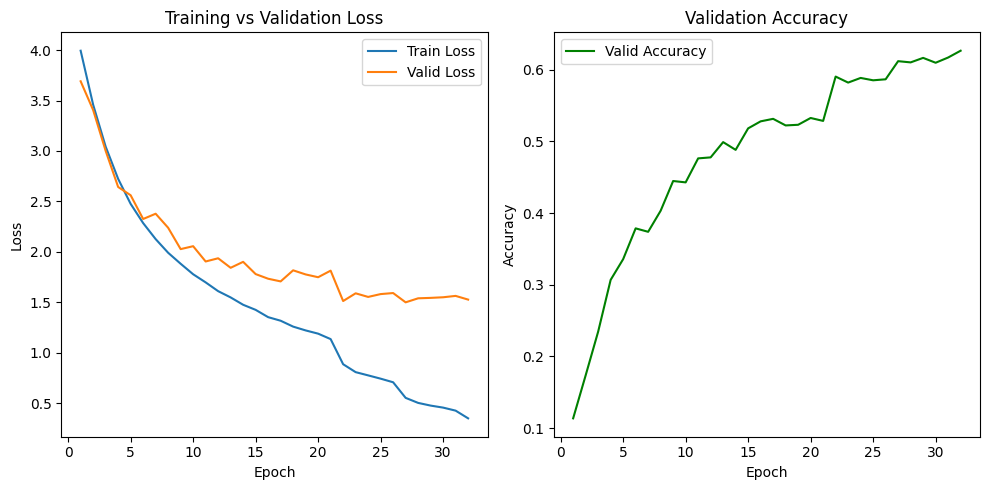

([3.993853161239624,
  3.4583449798583983,
  3.043210942840576,
  2.7233119968414305,
  2.475333088874817,
  2.284856153869629,
  2.1261718351364136,
  1.990658179664612,
  1.881723122215271,
  1.7776876270294188,
  1.6971406223297119,
  1.610049175453186,
  1.547984296131134,
  1.4750950830459595,
  1.4246723923683167,
  1.3523733125686646,
  1.3169104234695435,
  1.258552929019928,
  1.2208354325294495,
  1.1887396308898925,
  1.1347755321502686,
  0.8857255617618561,
  0.8071751853466034,
  0.7750768761634826,
  0.7424717410564423,
  0.7067680654525756,
  0.5522271815299988,
  0.5022077312231064,
  0.47554089119434356,
  0.455537868642807,
  0.4254578322410584,
  0.3491513294696808],
 [3.6906968848720476,
  3.4056432140860586,
  3.001138008324204,
  2.642795843683231,
  2.5607989882207978,
  2.325441225319152,
  2.377723555655996,
  2.2385286669822255,
  2.026898948250303,
  2.055797103863613,
  1.9043160456760673,
  1.936027315012209,
  1.8416807006119162,
  1.9007440942108251,
  1

In [ ]:
train_dataloader_model(model, train_loader, valid_loader, optim= optim, loss_fn= loss_fn)

In [ ]:
model.eval()
with torch.no_grad():
    epoch_test_loss = 0
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_test_pred = model(X_test)
        c_loss = loss_fn(y_test_pred, y_test)
        epoch_test_loss += c_loss.item()
    epoch_test_loss /= len(test_loader)
    print(epoch_test_loss)

1.4128906525624025
